# Test set evaluation 
We now use top models from the grid search to deploy on test

In [1]:
%load_ext autoreload
%autoreload 2

Note: the below is similar to the code seen in "protein-eval.py", use the selected models in notebook #4 to hardcode model strings

In [2]:
encoder_list = ["tile2vec", "ViT", "CLIP", "PLIP"]
test_metrics = ["auprc", "ap"]
# encoder_top_models = \
#     {'tile2vec': ('k15_r0_alpha0.010_tau2.00_lamnan.model', 0.4), \
#     'ViT':       ('k10_r2_alpha0.010_tau2.00_lamnan.model', 0.5), \
#     'CLIP':      ('k20_r0_alpha0.050_tau2.00_lamnan.model', 0.1), \
#     'PLIP':      ('k10_r0_alpha0.010_tau2.00_lamnan.model', 0.5)}
# baseline_top_models = \
#     {'ViT': [('attn_vit_iid', ">"), ("probs_vit_iid", ">")], \
#     'CLIP': [('probs_clip', ">")], \
#     'PLIP': [('probs_plip', ">")]}

encoder_top_models = \
    {'tile2vec': ('k20_r8_alpha10000000000.000_tau0.00_lamnan.model', 0.4), \
    'ViT':       ('k20_r2_alpha0.050_tau0.00_lamnan.model', 0.5), \
    'CLIP':      ('k30_r2_alpha10000000000.000_tau2.00_lamnan.model', 0.1), \
    'PLIP':      ('k15_r1_alpha0.010_tau2.00_lamnan.model', 0.5)}
baseline_top_models = \
    {'ViT': [('attn_vit_iid', ">"), ("probs_vit_iid", ">")], \
    'CLIP': [('probs_clip', ">")], \
    'PLIP': [('probs_plip', ">")]}

In [3]:
from evaluation import test_eval, extract_params, get_test_metrics
import utils
import pandas as pd

In [5]:
base_df = []
for encoder in ["ViT", "CLIP", "PLIP"]:
    for model_thresh_pair in baseline_top_models[encoder]:
        best_model, best_thresh = model_thresh_pair
        results_dict = utils.deserialize("/dfs/scratch1/gmachi/gcp_backup/k2/baselines/results_dict-" + best_model +".obj")
        df = get_test_metrics(results_dict, encoder, best_model, best_thresh, test_metrics)
        # add a "method" column to the df (K2, Attn, Prob)
        df["method"] = best_model.split("_")[0].title()
        base_df.append(df)
base_df = pd.concat(base_df)

In [6]:
# from evaluation import compute_seg_all_configs

# cache_dir = "/dfs/scratch1/gmachi/gcp_backup/k2/"
# Gs_dir = "/dfs/scratch1/gmachi/gcp_backup/data/tinycam/test/clean_Gs_"
# label_dict_path = "/dfs/scratch1/gmachi/gcp_backup/k2/refined_label_dicts/refined_test_labeldict-" 
# gts_path = "/dfs/scratch1/gmachi/gcp_backup/data/tinycam/test/gt_graphs_"

# test_df = compute_seg_all_configs(encoder_top_models, cache_dir, Gs_dir, gts_path, label_dict_path)

Note: the below cell takes about 8min to run

In [5]:
test_df = []
for encoder, (model_str, threshold) in encoder_top_models.items():
    if encoder == "ViT":
        encoder_alias = "vit_iid"
    else:
        encoder_alias = encoder.lower()
    cache_dir = "/dfs/scratch1/gmachi/gcp_backup/k2/" + encoder_alias + "_gridsearch/"
    results_cache_dir = cache_dir + encoder_alias + "-eval_results"
    model_cache_dir = cache_dir + encoder_alias + "-fitted_k2_models"
    processor_cache_dir = cache_dir + encoder_alias + "-fitted_k2_processors"
    linearized_cache_dir = cache_dir + encoder_alias + "-linearized_data"

    G_dir = "/dfs/scratch1/gmachi/gcp_backup/data/tinycam/test/clean_Gs_" + encoder_alias
    gt_dir = "/dfs/scratch1/gmachi/gcp_backup/data/tinycam/test/gt_graphs_" + encoder_alias
    label_dict = utils.deserialize("/dfs/scratch1/gmachi/gcp_backup/k2/refined_label_dicts/refined_test_labeldict-" + encoder_alias + ".obj")

    df = test_eval(model_str, threshold, test_metrics, model_cache_dir, processor_cache_dir, G_dir, gt_dir=gt_dir, label_dict=label_dict, modality="image", arm="test")
    df['method'] = 'K2'
    test_df.append(df)
test_df = pd.concat(test_df)

/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator KMeans from vers

In [6]:
combined_df = pd.concat([test_df, base_df])

mean_df = combined_df.groupby(['encoder', 'method','regime', 'metric'])['value'].mean().reset_index()
sem_df = combined_df.groupby(['encoder', 'method','regime', 'metric'])['value'].sem().reset_index()

mean_pvt = mean_df.pivot(index=['encoder', 'method', 'regime'], columns='metric', values='value')
mean_pvt = mean_pvt[test_metrics]

sem_pvt = sem_df.pivot(index=['encoder', 'method', 'regime'], columns='metric', values='value')
sem_pvt = sem_pvt[test_metrics]

#Save dfs
mean_pvt.to_csv('/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/all_test_results_mean-ALL.csv')
sem_pvt.to_csv('/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/all_test_results_sem-ALL.csv')
combined_df.to_csv('/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/all_test_results_points-ALL.csv') # graph-level results
test_df.to_csv('/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2_test_results_points-ALL.csv')  # k2 only


### Skip to here if you just want to read the csvs

In [4]:
combined_df = pd.read_csv('/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/all_test_results_points-ALL.csv') # graph-level results
test_df = pd.read_csv('/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2_test_results_points-ALL.csv')  # k2 only

# Properties vs performance

In [5]:
from evaluation import compute_test_mrds, compute_test_rps, compute_test_mcs, compute_test_ccs

gts_path = "/dfs/scratch1/gmachi/gcp_backup/data/tinycam/test/gt_graphs_"
rps_dict = compute_test_rps(gts_path + "plip")
mrds_dict = compute_test_mrds(gts_path + "plip")
ccs_dict = compute_test_ccs(gts_path + "plip")
mcs_dict = compute_test_mcs(gts_path + "plip")

/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dfs/scratch1/gmachi/k2/K2/src/evaluation.py:593: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(size_cc) / len(size_cc) # prevalence / num CC


In [6]:
# test_df['rp'] = test_df['datum_id'].map(rps_dict)
# test_df['mrd'] = test_df['datum_id'].map(mrds_dict)
# test_df['ccs'] = test_df['datum_id'].map(ccs_dict)
# test_df['mcs'] = test_df['datum_id'].map(mcs_dict)
# test_df['srp'] = test_df['rp'] / test_df['ccs']

combined_df['rp'] = combined_df['datum_id'].map(rps_dict)
combined_df['mrd'] = combined_df['datum_id'].map(mrds_dict)
combined_df['ccs'] = combined_df['datum_id'].map(ccs_dict)
combined_df['mcs'] = combined_df['datum_id'].map(mcs_dict)
combined_df['srp'] = combined_df['rp'] / combined_df['ccs']

In [7]:
# test_df
combined_df

,Unnamed: 0,encoder,model,threshold,datum_id,regime,metric,value,method,rp,mrd,ccs,mcs,srp
0,0,tile2vec,k20_r8_alpha10000000000.000_tau0.00_lamnan.model,0.4,G-test_109,all,auprc,NaN,K2,0.000000,NaN,0,NaN,NaN
1,1,tile2vec,k20_r8_alpha10000000000.000_tau0.00_lamnan.model,0.4,G-test_109,all,ap,NaN,K2,0.000000,NaN,0,NaN,NaN
2,2,tile2vec,k20_r8_alpha10000000000.000_tau0.00_lamnan.model,0.4,G-test_073,all,auprc,0.279330,K2,0.260241,1.12037,11,9.818182,0.023658
3,3,tile2vec,k20_r8_alpha10000000000.000_tau0.00_lamnan.model,0.4,G-test_073,all,ap,0.284919,K2,0.260241,1.12037,11,9.818182,0.023658
4,4,tile2vec,k20_r8_alpha10000000000.000_tau0.00_lamnan.model,0.4,G-test_103,all,auprc,NaN,K2,0.000000,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1963,241,PLIP,probs_plip,"('>', 0.8201786795623688)",G-test_005,all,ap,NaN,Probs,0.000000,NaN,0,NaN,NaN
1964,242,PLIP,probs_plip,"('>', 0.7910620937021333)",G-test_023,all,auprc,NaN,Probs,0.000000,NaN,0,NaN,NaN
1965,243,PLIP,probs_plip,"('>', 0.7910620937021333)",G-test_023,all,ap,NaN,Probs,0.000000,NaN,0,NaN,NaN
1966,244,PLIP,probs_plip,"('>', 0.9839768032484416)",G-test_020,all,auprc,NaN,Probs,0.000000,NaN,0,NaN,NaN


In [8]:
set(combined_df["method"])

{'Attn', 'K2', 'Probs'}

no edits needed to labels/legend...

In [9]:
combined_df.loc[combined_df['method'].str.contains('Attn'), 'method'] = 'Attention'
combined_df.loc[combined_df['method'].str.contains('Probs'), 'method'] = 'Probability'
combined_df.loc[combined_df['method'].str.contains('K2'), 'method'] = 'Prospector'
top_baseline_method = "Probability"
top_baseline_encoder = "ViT"

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils

def setup_figure(width=6, height=3):
    sns.set(style='white')
    sns.set_context('paper')
    plt.figure(figsize=(width,height))
    
pal = sns.color_palette('tab20')

In [11]:
met="auprc"
# filtered_df = test_df[test_df['metric'] == met]
filtered_df = combined_df[(combined_df['metric'] == met) & (combined_df['method'].isin(["Prospector", top_baseline_method]))]
filtered_df["pipeline"] = filtered_df["encoder"] + "-" + filtered_df["method"]
filtered_df = filtered_df[(filtered_df['pipeline'].str.contains("Prospector")) | (filtered_df['pipeline'] == top_baseline_encoder + "-" + top_baseline_method)]


/tmp/ipykernel_56588/3237447435.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pipeline"] = filtered_df["encoder"] + "-" + filtered_df["method"]


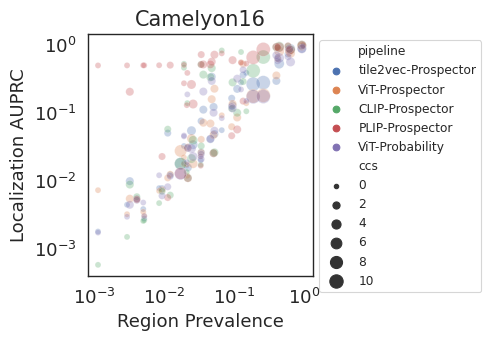

In [12]:
setup_figure(5,3.5)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.4, s=100)
g = sns.scatterplot(data=filtered_df, x="rp", y="value", hue="pipeline", size="ccs", sizes=(10, 100), alpha=0.3)


g.set_xscale("log")
g.set_yscale("log")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Region Prevalence', fontsize=13)
g.set_ylabel('Localization AUPRC', fontsize=13)
g.tick_params(labelsize=13)
g.set_title("Camelyon16", fontsize=15)


plt.tight_layout()
plt.savefig("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2-rp_cam_auprc.png", dpi=300, format='png')
plt.show()


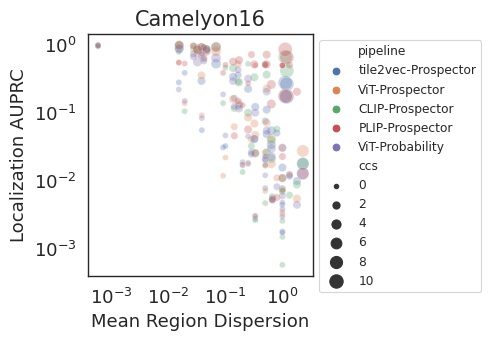

In [13]:
setup_figure(5,3.5)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.4, s=100)
# g = sns.scatterplot(data=filtered_df, x="mrd", y="value", hue="encoder", size="ccs", sizes=(10, 100), alpha=0.3)
g = sns.scatterplot(data=filtered_df, x="mrd", y="value", hue="pipeline", size="ccs", sizes=(10, 100), alpha=0.3)

g.set_xscale("log")
g.set_yscale("log")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Mean Region Dispersion', fontsize=13)
g.set_ylabel('Localization AUPRC', fontsize=13)
g.tick_params(labelsize=13)
g.set_title("Camelyon16", fontsize=15)


plt.tight_layout()
plt.savefig("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2-mrd_cam_auprc.png", dpi=300, format='png')
plt.show()

In [14]:
# g = sns.scatterplot(data=test_df, x="mcs", y="value", hue="encoder", size="ccs", sizes=(40, 300), alpha=0.4)
# # g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.4, s=100)
# g.set_xscale("log")
# g.set_yscale("log")
# _ = g.set(xlabel="Mean Component Size", ylabel="Segmentation AUPRC")
# g.set_title("Impact of test-set MCS for segmentation")

In [15]:
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", size="mrd", sizes=(40, 300), alpha=0.4)
# # g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.4, s=100)
# g.set_xscale("log")
# g.set_yscale("log")
# _ = g.set(xlabel="Region Prevalence", ylabel="Segmentation AUPRC")
# g.set_title("Impact of test-set RP for segmentation")

In [16]:
met="ap"
# filtered_df = test_df[test_df['metric'] == met]
filtered_df = combined_df[(combined_df['metric'] == met) & (combined_df['method'].isin(["Prospector", top_baseline_method]))]
filtered_df["pipeline"] = filtered_df["encoder"] + "-" + filtered_df["method"]
filtered_df = filtered_df[(filtered_df['pipeline'].str.contains("Prospector")) | (filtered_df['pipeline'] == top_baseline_encoder + "-" + top_baseline_method)]


/tmp/ipykernel_56588/388827144.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pipeline"] = filtered_df["encoder"] + "-" + filtered_df["method"]


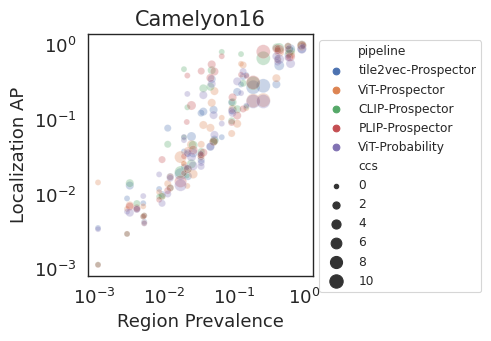

In [17]:
setup_figure(5,3.5)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.4, s=100)
# g = sns.scatterplot(data=filtered_df, x="rp", y="value", hue="encoder", size="ccs", sizes=(10, 100), alpha=0.3)
g = sns.scatterplot(data=filtered_df, x="rp", y="value", hue="pipeline", size="ccs", sizes=(10, 100), alpha=0.3)

g.set_xscale("log")
g.set_yscale("log")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Region Prevalence', fontsize=13)
g.set_ylabel('Localization AP', fontsize=13)
g.tick_params(labelsize=13)
g.set_title("Camelyon16", fontsize=15)


plt.tight_layout()
plt.savefig("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2-rp_cam_ap.png", dpi=300, format='png')
plt.show()


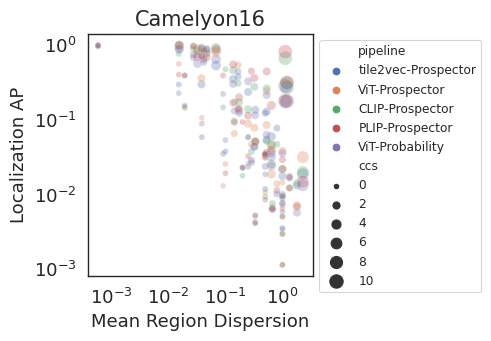

In [18]:
setup_figure(5,3.5)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.4, s=100)
# g = sns.scatterplot(data=filtered_df, x="mrd", y="value", hue="encoder", size="ccs", sizes=(10, 100), alpha=0.3)
g = sns.scatterplot(data=filtered_df, x="mrd", y="value", hue="pipeline", size="ccs", sizes=(10, 100), alpha=0.3)

g.set_xscale("log")
g.set_yscale("log")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Mean Region Dispersion', fontsize=13)
g.set_ylabel('Localization AP', fontsize=13)
g.tick_params(labelsize=13)
g.set_title("Camelyon16", fontsize=15)


plt.tight_layout()
plt.savefig("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2-mrd_cam_ap.png", dpi=300, format='png')
plt.show()

# adding rolling averages

In [19]:
import numpy as np
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'full')

In [20]:
met="auprc"
# filtered_df = test_df[test_df['metric'] == met]
filtered_df = combined_df[(combined_df['metric'] == met) & (combined_df['method'].isin(["Prospector", top_baseline_method]))]
filtered_df["pipeline"] = filtered_df["encoder"] + "-" + filtered_df["method"]
filtered_df = filtered_df[(filtered_df['pipeline'].str.contains("Prospector")) | (filtered_df['pipeline'] == top_baseline_encoder + "-" + top_baseline_method)]

/tmp/ipykernel_56588/482498704.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pipeline"] = filtered_df["encoder"] + "-" + filtered_df["method"]


/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


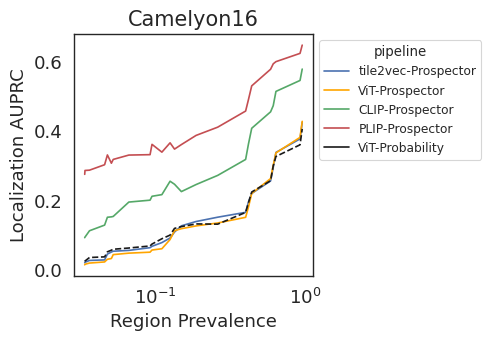

In [21]:
# running_means = filtered_df.sort_values('rp').groupby('encoder').apply(lambda x: movingaverage(x['value'], 20))
# mean_data = []
# for enc, df in filtered_df.sort_values('rp').groupby('encoder'):
#     mean_data.extend(list(zip(df['rp'], running_means[enc], [enc]*len(df))))
# mean_data = pd.DataFrame(mean_data, columns=['rp', 'value', 'encoder'])

running_means = filtered_df.sort_values('rp').groupby('pipeline').apply(lambda x: movingaverage(x['value'], 20))
mean_data = []
for enc, df in filtered_df.sort_values('rp').groupby('pipeline'):
    mean_data.extend(list(zip(df['rp'], running_means[enc], [enc]*len(df))))
mean_data = pd.DataFrame(mean_data, columns=['rp', 'value', 'pipeline'])


setup_figure(5,3.5)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", size="ccs", sizes=(10, 100), alpha=0.3)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.4, s=100)
# g = sns.lineplot(data=mean_data.reset_index(), x='rp', y='value', hue='encoder', hue_order=['tile2vec', 'ViT', 'CLIP', 'PLIP'])
g = sns.lineplot(data=mean_data.reset_index(), x='rp', y='value', hue='pipeline', 
                hue_order=['tile2vec-Prospector', 'ViT-Prospector', 'CLIP-Prospector', 'PLIP-Prospector', 'ViT-Probability'],
                palette=['b', "orange", "g", "r", 'k'])
g.lines[4].set_linestyle("--")


g.set_xscale("log")
# g.set_xlim(8e-2, 1e0) # added for clarity
 
# g.set_yscale("log")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Region Prevalence', fontsize=13)
g.set_ylabel('Localization AUPRC', fontsize=13)
g.tick_params(labelsize=13)
g.set_title("Camelyon16", fontsize=15)
plt.tight_layout()
plt.savefig("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2-rp_" + met + "cam_LINE.png", dpi=300, format='png')
plt.show()

/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


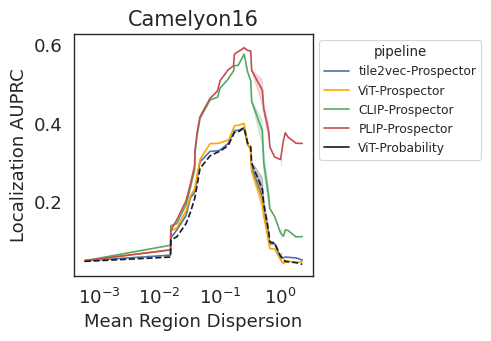

In [22]:
# running_means = filtered_df.sort_values('mrd').groupby('encoder').apply(lambda x: movingaverage(x['value'], 20))
# mean_data = []
# for enc, df in filtered_df.sort_values('mrd').groupby('encoder'):
#     mean_data.extend(list(zip(df['mrd'], running_means[enc], [enc]*len(df))))
# mean_data = pd.DataFrame(mean_data, columns=['mrd', 'value', 'encoder'])

running_means = filtered_df.sort_values('mrd').groupby('pipeline').apply(lambda x: movingaverage(x['value'], 20))
mean_data = []
for enc, df in filtered_df.sort_values('mrd').groupby('pipeline'):
    mean_data.extend(list(zip(df['mrd'], running_means[enc], [enc]*len(df))))
mean_data = pd.DataFrame(mean_data, columns=['mrd', 'value', 'pipeline'])


# met = test_metrics[0]
setup_figure(5,3.5)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", size="ccs", sizes=(10, 100), alpha=0.3)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.4, s=100)
# g = sns.lineplot(data=mean_data.reset_index(), x='mrd', y='value', hue='encoder', hue_order=['tile2vec', 'ViT', 'CLIP', 'PLIP'])
g = sns.lineplot(data=mean_data.reset_index(), x='mrd', y='value', hue='pipeline', 
                hue_order=['tile2vec-Prospector', 'ViT-Prospector', 'CLIP-Prospector', 'PLIP-Prospector', 'ViT-Probability'],
                palette=['b', "orange", "g", "r", 'k'])
g.lines[4].set_linestyle("--")


g.set_xscale("log")
# g.set_yscale("log")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Mean Region Dispersion', fontsize=13)
g.set_ylabel('Localization AUPRC', fontsize=13)
g.tick_params(labelsize=13)
g.set_title("Camelyon16", fontsize=15)
plt.tight_layout()
plt.savefig("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2-mrd_" + met + "cam_LINE.png", dpi=300, format='png')
plt.show()

In [23]:
met="ap"
# filtered_df = test_df[test_df['metric'] == met]
filtered_df = combined_df[(combined_df['metric'] == met) & (combined_df['method'].isin(["Prospector", top_baseline_method]))]
filtered_df["pipeline"] = filtered_df["encoder"] + "-" + filtered_df["method"]
filtered_df = filtered_df[(filtered_df['pipeline'].str.contains("Prospector")) | (filtered_df['pipeline'] == top_baseline_encoder + "-" + top_baseline_method)]

/tmp/ipykernel_56588/179844255.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pipeline"] = filtered_df["encoder"] + "-" + filtered_df["method"]


/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


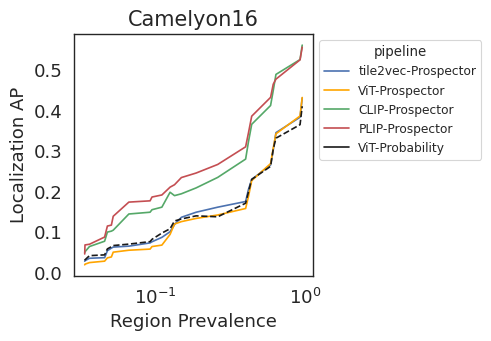

In [24]:
# running_means = filtered_df.sort_values('rp').groupby('encoder').apply(lambda x: movingaverage(x['value'], 20))
# mean_data = []
# for enc, df in filtered_df.sort_values('rp').groupby('encoder'):
#     mean_data.extend(list(zip(df['rp'], running_means[enc], [enc]*len(df))))
# mean_data = pd.DataFrame(mean_data, columns=['rp', 'value', 'encoder'])

running_means = filtered_df.sort_values('rp').groupby('pipeline').apply(lambda x: movingaverage(x['value'], 20))
mean_data = []
for enc, df in filtered_df.sort_values('rp').groupby('pipeline'):
    mean_data.extend(list(zip(df['rp'], running_means[enc], [enc]*len(df))))
mean_data = pd.DataFrame(mean_data, columns=['rp', 'value', 'pipeline'])

# met = test_metrics[0]
setup_figure(5,3.5)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", size="ccs", sizes=(10, 100), alpha=0.3)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.4, s=100)
# g = sns.lineplot(data=mean_data.reset_index(), x='rp', y='value', hue='encoder', hue_order=['tile2vec', 'ViT', 'CLIP', 'PLIP'])
g = sns.lineplot(data=mean_data.reset_index(), x='rp', y='value', hue='pipeline', 
                hue_order=['tile2vec-Prospector', 'ViT-Prospector', 'CLIP-Prospector', 'PLIP-Prospector', 'ViT-Probability'],
                palette=['b', "orange", "g", "r", 'k'])
g.lines[4].set_linestyle("--")

g.set_xscale("log")
# g.set_xlim(8e-2, 1e0) # added for clarity
 
# g.set_yscale("log")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Region Prevalence', fontsize=13)
g.set_ylabel('Localization AP', fontsize=13)
g.tick_params(labelsize=13)
g.set_title("Camelyon16", fontsize=15)
plt.tight_layout()
plt.savefig("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2-rp_" + met + "cam_LINE.png", dpi=300, format='png')
plt.show()

/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


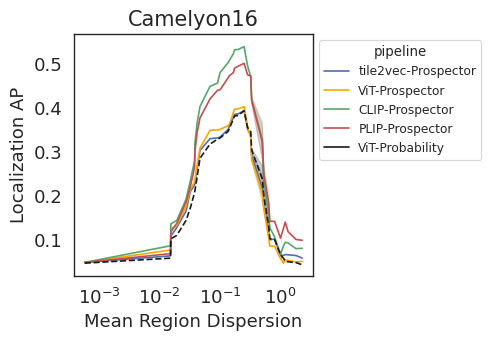

In [25]:
# running_means = filtered_df.sort_values('mrd').groupby('encoder').apply(lambda x: movingaverage(x['value'], 20))
# mean_data = []
# for enc, df in filtered_df.sort_values('mrd').groupby('encoder'):
#     mean_data.extend(list(zip(df['mrd'], running_means[enc], [enc]*len(df))))
# mean_data = pd.DataFrame(mean_data, columns=['mrd', 'value', 'encoder'])

running_means = filtered_df.sort_values('mrd').groupby('pipeline').apply(lambda x: movingaverage(x['value'], 20))
mean_data = []
for enc, df in filtered_df.sort_values('mrd').groupby('pipeline'):
    mean_data.extend(list(zip(df['mrd'], running_means[enc], [enc]*len(df))))
mean_data = pd.DataFrame(mean_data, columns=['mrd', 'value', 'pipeline'])

# met = test_metrics[0]
setup_figure(5,3.5)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", size="ccs", sizes=(10, 100), alpha=0.3)
# g = sns.scatterplot(data=test_df, x="rp", y="value", hue="encoder", alpha=0.4, s=100)
# g = sns.lineplot(data=mean_data.reset_index(), x='mrd', y='value', hue='encoder', hue_order=['tile2vec', 'ViT', 'CLIP', 'PLIP'])
g = sns.lineplot(data=mean_data.reset_index(), x='mrd', y='value', hue='pipeline', 
                hue_order=['tile2vec-Prospector', 'ViT-Prospector', 'CLIP-Prospector', 'PLIP-Prospector', 'ViT-Probability'],
                palette=['b', "orange", "g", "r", 'k'])
g.lines[4].set_linestyle("--")

g.set_xscale("log")
# g.set_yscale("log")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Mean Region Dispersion', fontsize=13)
g.set_ylabel('Localization AP', fontsize=13)
g.tick_params(labelsize=13)
g.set_title("Camelyon16", fontsize=15)
plt.tight_layout()
plt.savefig("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2-mrd_" + met + "cam_LINE.png", dpi=300, format='png')
plt.show()

# plotting test set results

In [26]:
def setup_figure(width=6, height=3):
    sns.set(style='white')
    sns.set_context('paper')
    plt.figure(figsize=(width,height))
    
pal = sns.color_palette('tab20')

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils


# combined_df = pd.read_csv("/home/k2/K2/src/outputs/k2-test/all_test_results_points.csv")
# combined_df = pd.read_csv("/dfs/scratch1/gmachi/gcp_backup/k2/k2-test/all_test_results_points.csv")
combined_df = pd.read_csv("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/all_test_results_points-ALL.csv")


In [28]:
combined_df.head()

,Unnamed: 0,encoder,model,threshold,datum_id,regime,metric,value,method
0,0,tile2vec,k20_r8_alpha10000000000.000_tau0.00_lamnan.model,0.4,G-test_109,all,auprc,NaN,K2
1,1,tile2vec,k20_r8_alpha10000000000.000_tau0.00_lamnan.model,0.4,G-test_109,all,ap,NaN,K2
2,2,tile2vec,k20_r8_alpha10000000000.000_tau0.00_lamnan.model,0.4,G-test_073,all,auprc,0.279330,K2
3,3,tile2vec,k20_r8_alpha10000000000.000_tau0.00_lamnan.model,0.4,G-test_073,all,ap,0.284919,K2
4,4,tile2vec,k20_r8_alpha10000000000.000_tau0.00_lamnan.model,0.4,G-test_103,all,auprc,NaN,K2


In [29]:
combined_df[combined_df.metric == "auprc"].reset_index()

,index,Unnamed: 0,encoder,model,threshold,datum_id,regime,metric,value,method
0,0,0,tile2vec,k20_r8_alpha10000000000.000_tau0.00_lamnan.model,0.4,G-test_109,all,auprc,NaN,K2
1,2,2,tile2vec,k20_r8_alpha10000000000.000_tau0.00_lamnan.model,0.4,G-test_073,all,auprc,0.279330,K2
2,4,4,tile2vec,k20_r8_alpha10000000000.000_tau0.00_lamnan.model,0.4,G-test_103,all,auprc,NaN,K2
3,6,6,tile2vec,k20_r8_alpha10000000000.000_tau0.00_lamnan.model,0.4,G-test_079,all,auprc,0.033965,K2
4,8,8,tile2vec,k20_r8_alpha10000000000.000_tau0.00_lamnan.model,0.4,G-test_036,all,auprc,NaN,K2
...,...,...,...,...,...,...,...,...,...,...
979,1958,236,PLIP,probs_plip,"('>', 0.813513993490033)",G-test_113,all,auprc,0.542367,Probs
980,1960,238,PLIP,probs_plip,"('>', 0.8389154101742639)",G-test_063,all,auprc,NaN,Probs
981,1962,240,PLIP,probs_plip,"('>', 0.8201786795623688)",G-test_005,all,auprc,NaN,Probs
982,1964,242,PLIP,probs_plip,"('>', 0.7910620937021333)",G-test_023,all,auprc,NaN,Probs


In [30]:
# rename methods, model
combined_df.loc[combined_df['method'].str.contains('Attn'), 'method'] = 'Attention'
combined_df.loc[combined_df['method'].str.contains('Probs'), 'method'] = 'Probability'
combined_df.loc[combined_df['method'].str.contains('K2'), 'method'] = 'Prospector'

In [31]:
test_metrics = ["auprc"]

/tmp/ipykernel_56588/1396351039.py:11: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.stripplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value',  hue='method', hue_order=hue_order, orient='vertical', dodge=True, alpha=0.1, linewidth=0.5, ax=ax, legend=False)
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


nan
0.1583406337939264
nan
nan
0.21177778688876103
0.2103815366727272
0.3296397801857319
0.47040438601186213
nan
0.20692406371934888
0.14930138998877643
0.16284665276468172


<Figure size 640x480 with 0 Axes>

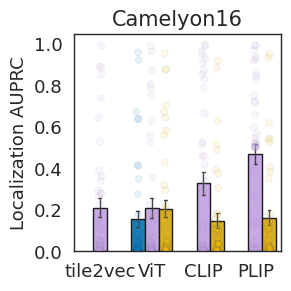

In [32]:
for met in test_metrics:
    subdf = combined_df[combined_df.metric == met].reset_index()
    plt.clf()
    # p=sns.color_palette("Set1")
    # colors at: https://xkcd.com/color/rgb/
    p=sns.xkcd_palette(["cerulean","lavender","goldenrod","violet","vermillion","fuchsia","celadon","mahogany"])
    if met == 'auprc':
        setup_figure(3,3) #3,3
        hue_order = ['Attention', 'Prospector', 'Probability']
        ax = sns.barplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value', hue='method', hue_order=hue_order, orient='vertical', errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="k")
        sns.stripplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value',  hue='method', hue_order=hue_order, orient='vertical', dodge=True, alpha=0.1, linewidth=0.5, ax=ax, legend=False)
        plt.title("Camelyon16", fontsize=15)
        ax.set_ylabel('Localization AUPRC', fontsize=13)
        ax.set_xlabel('')
        ax.tick_params(labelsize=13)
        for p in ax.patches:
            y = p.get_height()
            print(y)
        # plt.legend(loc='upper left')
        # plt.legend(loc=(1.01,0.75))
        ax.legend_.remove()
        # plt.legend(loc="upper right", bbox_to_anchor=(1.01, 0.8))
    else:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 3), sharey=True, gridspec_kw={'wspace': 0})
        sns.barplot(data=subdf[subdf['regime'] == 'class-1'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, ax=ax2, errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="w")
        sns.stripplot(data=subdf[subdf['regime'] == 'class-1'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, alpha=0.1, linewidth=0.5, ax=ax2, legend=False)
        # ax1.yaxis.set_label_position('left')

        ax2.set_title('  '+'class-1', loc='left')
        ax2.set_ylabel('')
        ax2.set_yticklabels([])
        ax2.legend_.remove()
    
        sns.barplot(data=subdf[subdf['regime'] == 'all'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, ax=ax1, errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="k")
        sns.stripplot(data=subdf[subdf['regime'] == 'all'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, alpha=0.1, linewidth=0.5, ax=ax1, legend=False)
        ax1.legend_.remove()
    
        # optionally use the same scale left and right
        xmax = max(ax1.get_xlim()[1], ax2.get_xlim()[1])
        ax1.set_xlim(xmax=xmax)
        ax2.set_xlim(xmax=xmax)

        ax1.invert_xaxis()  # reverse the direction
        ax1.tick_params(axis='y', labelleft=True, left=True, labelright=False, right=False)
        ax1.set_ylabel('')
        ax1.set_title('all data'+'  ', loc='right')

        plt.legend(loc=(-1.01,1.02))
        fig.suptitle(met, fontsize=15)
    
    plt.tight_layout()
    # plt.savefig("/home/k2/K2/src/outputs/k2-test/k2-vs-baseline_" + met + ".png", dpi=2000, format='png')
    plt.savefig("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2-vs-baseline_cam_" + met + ".png", dpi=2000, format='png')
    plt.show()

In [33]:
subdf[subdf.regime == 'all'].groupby(['encoder','method'])['value'].describe()[['mean','std']]

mean       std
encoder  method                         
CLIP     Probability  0.149301  0.227527
         Prospector   0.329640  0.368094
PLIP     Probability  0.162847  0.244434
         Prospector   0.470404  0.325640
ViT      Attention    0.158341  0.251148
         Probability  0.206924  0.279711
         Prospector   0.210382  0.307022
tile2vec Prospector   0.211778  0.287793

In [34]:
subdf[subdf.regime == 'all'].groupby(['encoder','method'])['value'].sem()

encoder   method     
CLIP      Probability    0.034698
          Prospector     0.056134
PLIP      Probability    0.037276
          Prospector     0.049660
ViT       Attention      0.038300
          Probability    0.042655
          Prospector     0.046820
tile2vec  Prospector     0.043888
Name: value, dtype: float64

In [35]:
test_metrics = ["ap"]

/tmp/ipykernel_56588/779846367.py:11: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.stripplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value',  hue='method', hue_order=hue_order, orient='vertical', dodge=True, alpha=0.1, linewidth=0.5, ax=ax, legend=False)
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


nan
0.16244295927215385
nan
nan
0.2184858042454494
0.21513179989126935
0.29800837365554966
0.3002719745548068
nan
0.21202312331334805
0.15494203760934425
0.16749112072252167


<Figure size 640x480 with 0 Axes>

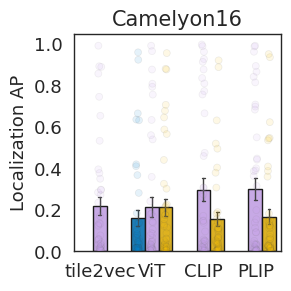

In [36]:
for met in test_metrics:
    subdf = combined_df[combined_df.metric == met].reset_index()
    plt.clf()
    # p=sns.color_palette("Set1")
    # colors at: https://xkcd.com/color/rgb/
    p=sns.xkcd_palette(["cerulean","lavender","goldenrod","violet","vermillion","fuchsia","celadon","mahogany"])
    if met == 'ap':
        setup_figure(3,3)
        hue_order = ['Attention', 'Prospector', 'Probability']
        ax = sns.barplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value', hue='method', hue_order=hue_order, orient='vertical', errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="k")
        sns.stripplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value',  hue='method', hue_order=hue_order, orient='vertical', dodge=True, alpha=0.1, linewidth=0.5, ax=ax, legend=False)
        plt.title("Camelyon16", fontsize=15)
        ax.set_ylabel('Localization AP', fontsize=13)
        ax.set_xlabel('')
        ax.tick_params(labelsize=13)
        for p in ax.patches:
            y = p.get_height()
            print(y)
        # plt.legend(loc='upper left')
        # plt.legend(loc=(1.01,0.75))
        ax.legend_.remove()
        # plt.legend(loc=(0.65,1.01))
    else:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 3), sharey=True, gridspec_kw={'wspace': 0})
        sns.barplot(data=subdf[subdf['regime'] == 'class-1'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, ax=ax2, errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="w")
        sns.stripplot(data=subdf[subdf['regime'] == 'class-1'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, alpha=0.1, linewidth=0.5, ax=ax2, legend=False)
        # ax1.yaxis.set_label_position('left')

        ax2.set_title('  '+'class-1', loc='left')
        ax2.set_ylabel('')
        ax2.set_yticklabels([])
        ax2.legend_.remove()
    
        sns.barplot(data=subdf[subdf['regime'] == 'all'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, ax=ax1, errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="k")
        sns.stripplot(data=subdf[subdf['regime'] == 'all'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, alpha=0.1, linewidth=0.5, ax=ax1, legend=False)
        ax1.legend_.remove()
    
        # optionally use the same scale left and right
        xmax = max(ax1.get_xlim()[1], ax2.get_xlim()[1])
        ax1.set_xlim(xmax=xmax)
        ax2.set_xlim(xmax=xmax)

        ax1.invert_xaxis()  # reverse the direction
        ax1.tick_params(axis='y', labelleft=True, left=True, labelright=False, right=False)
        ax1.set_ylabel('')
        ax1.set_title('all data'+'  ', loc='right')

        plt.legend(loc=(-1.01,1.02))
        fig.suptitle(met, fontsize=15)
    
    plt.tight_layout()
    # plt.savefig("/home/k2/K2/src/outputs/k2-test/k2-vs-baseline_" + met + ".png", dpi=2000, format='png')
    plt.savefig("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/k2-vs-baseline_cam_" + met + ".png", dpi=2000, format='png')
    plt.show()

In [37]:
subdf[subdf.regime == 'all'].groupby(['encoder','method'])['value'].describe()[['mean','std']]

mean       std
encoder  method                         
CLIP     Probability  0.154942  0.226136
         Prospector   0.298008  0.358802
PLIP     Probability  0.167491  0.243701
         Prospector   0.300272  0.341794
ViT      Attention    0.162443  0.248931
         Probability  0.212023  0.278871
         Prospector   0.215132  0.305948
tile2vec Prospector   0.218486  0.286830

In [38]:
subdf[subdf.regime == 'all'].groupby(['encoder','method'])['value'].sem()

encoder   method     
CLIP      Probability    0.034485
          Prospector     0.054717
PLIP      Probability    0.037164
          Prospector     0.052123
ViT       Attention      0.037962
          Probability    0.042527
          Prospector     0.046657
tile2vec  Prospector     0.043741
Name: value, dtype: float64

/tmp/ipykernel_56588/2773169989.py:11: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.stripplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value',  hue='method', hue_order=hue_order, orient='vertical', dodge=True, alpha=0.1, linewidth=0.5, ax=ax, legend=False)
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


nan
0.16244295927215385
nan
nan
0.2184858042454494
0.21513179989126935
0.29800837365554966
0.3002719745548068
nan
0.21202312331334805
0.15494203760934425
0.16749112072252167


<Figure size 640x480 with 0 Axes>

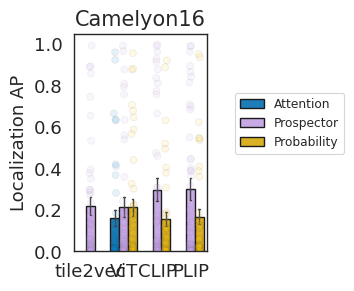

In [39]:
for met in test_metrics:
    subdf = combined_df[combined_df.metric == met].reset_index()
    plt.clf()
    # p=sns.color_palette("Set1")
    # colors at: https://xkcd.com/color/rgb/
    p=sns.xkcd_palette(["cerulean","lavender","goldenrod","violet","vermillion","fuchsia","celadon","mahogany"])
    if met == 'ap':
        setup_figure(4,3)
        hue_order = ['Attention', 'Prospector', 'Probability']
        ax = sns.barplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value', hue='method', hue_order=hue_order, orient='vertical', errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="k")
        sns.stripplot(data=subdf[subdf.regime == 'all'], palette=p, x='encoder', y='value',  hue='method', hue_order=hue_order, orient='vertical', dodge=True, alpha=0.1, linewidth=0.5, ax=ax, legend=False)
        plt.title("Camelyon16", fontsize=15)
        ax.set_ylabel('Localization AP', fontsize=13)
        ax.set_xlabel('')
        ax.tick_params(labelsize=13)
        for p in ax.patches:
            y = p.get_height()
            print(y)
        # plt.legend(loc='upper left')
        plt.legend(loc=(1.21,0.45))
        # ax.legend_.remove()
        # plt.legend(loc=(0.65,1.01))
    else:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 3), sharey=True, gridspec_kw={'wspace': 0})
        sns.barplot(data=subdf[subdf['regime'] == 'class-1'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, ax=ax2, errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="w")
        sns.stripplot(data=subdf[subdf['regime'] == 'class-1'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, alpha=0.1, linewidth=0.5, ax=ax2, legend=False)
        # ax1.yaxis.set_label_position('left')

        ax2.set_title('  '+'class-1', loc='left')
        ax2.set_ylabel('')
        ax2.set_yticklabels([])
        ax2.legend_.remove()
    
        sns.barplot(data=subdf[subdf['regime'] == 'all'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, ax=ax1, errorbar='se', capsize=0.05, errwidth=1.0, linewidth=1, edgecolor="k")
        sns.stripplot(data=subdf[subdf['regime'] == 'all'], x='value', y='encoder', hue='method', orient='horizontal', dodge=True, alpha=0.1, linewidth=0.5, ax=ax1, legend=False)
        ax1.legend_.remove()
    
        # optionally use the same scale left and right
        xmax = max(ax1.get_xlim()[1], ax2.get_xlim()[1])
        ax1.set_xlim(xmax=xmax)
        ax2.set_xlim(xmax=xmax)

        ax1.invert_xaxis()  # reverse the direction
        ax1.tick_params(axis='y', labelleft=True, left=True, labelright=False, right=False)
        ax1.set_ylabel('')
        ax1.set_title('all data'+'  ', loc='right')

        plt.legend(loc=(-1.01,1.02))
        fig.suptitle(met, fontsize=15)
    
    plt.tight_layout()
    # plt.savefig("/home/k2/K2/src/outputs/k2-test/k2-vs-baseline_" + met + ".png", dpi=2000, format='png')
    plt.savefig("/dfs/scratch1/gmachi/k2/K2/src/outputs/k2-test/cam-legend" + met + ".png", dpi=2000, format='png')
    plt.show()